# Intro

Here we use ALL perturbed cell-types.
This is done when we generate the pseudobulks by sampling from both perturbed or non-perturbed cells within each sample.

This notebook QCs the Kang et.al. data to make sure everything looks good.
The data was retreived using  the SeuratData package in R and then translated into an AnnData object to be read into python,
Notebook for SeuratData analysis of Kang data (names ifnb in SeuratData): https://satijalab.org/seurat/articles/integration_introduction.html
Seurat Disk was used for conversion between h5Seurat and AnnData: https://mojaveazure.github.io/seurat-disk/articles/convert-anndata.html

Kang data is originally from here: 
Kang, Hyun Min, et al. "Multiplexed droplet single-cell RNA-sequencing using natural genetic variation." Nature biotechnology 36.1 (2018): 89-94.


Data format requirements for single-cell data:
- processed data is not scaled
- cells are filtered such that low-quality cells are removed (for example: filter out cells with less than 200 genes and genes expressed in less than 3 cells, and > 5% MT reads)
- data is saved as an AnnData object and you have sample IDs, gene IDs, and cell-type labels
- In the end we will process the data such that we have the following features in the AnnData object that we will use to generate pseudobulks:
  - the observations have columns named: "sample_id", "stim", "isTraining"
  - sample_id: unique IDs for the samples
  - stim: is "STIM" or "CTRL", denotes if the sample is "Female" or "Male"
  - isTraining: 'Train' or 'Test',  denotes if you can use the sample during training or not. In real use cases, all data will be "Train". To show validation of our experiment, we have access to "Test" data as well. Train and test are separated on the cell level and are stratified by cell-type, sex, and sample ID
  


Pseudobulk features:
- we typically generate 1000 pseudobulks per sample with random proportions
- we generate 100 pseudobulks per sample, per cell type, where the cell-type of interest is >90% of the cell-type
- we typically sample 5000 cells for each pseudobulk

# Imports

In [1]:
import sys
sys.path.insert(1, '../../')
sys.path.insert(1, '../')
from buddi import buddi

from buddi.preprocessing import sc_preprocess


# general imports
import warnings
import numpy as np
import os
import pandas as pd
import scipy as sp
from scipy.sparse import coo_matrix
import collections
import scanpy as sc


# Images, plots, display, and visualization
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from sklearn.manifold import TSNE
import sklearn as sk

# matplotlib settings for Jupyter notebooks only
%matplotlib inline

import pickle
import gzip
from pathlib import Path


/Users/davidnat/Documents/projects/greenelab/buddi_test/.venv/lib/python3.10/site-packages/umap/distances.py:1063: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/Users/davidnat/Documents/projects/greenelab/buddi_test/.venv/lib/python3.10/site-packages/umap/distances.py:1071: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/Users/davidnat/

In [2]:
from importlib import reload  # Python 3.4+
reload(sc_preprocess)


<module 'buddi.preprocessing.sc_preprocess' from '/Users/davidnat/Documents/projects/greenelab/buddi/buddi/preprocessing/sc_preprocess.py'>

# Parameters

In [3]:
# parameters

aug_data_path = f"{os.getcwd()}/../../data/single_cell_data/augmented_sciplex_data/"
cibersort_path = f"{os.getcwd()}/../../data/single_cell_data/cibersort_sciplex/"
data_path = f"{os.getcwd()}/../../data/single_cell_data/sciplex/"



#####################
### set the study ###
#####################

res_name = "all-sciplex"
in_name = "sciplex_processed"
processed_sc_file = f"{data_path}/{in_name}.h5ad"



# Load and Process data

### Read in data and metadata

In [4]:
# read in the data

adata = sc.read_h5ad(processed_sc_file)

adata.var_names_make_unique()  # this is unnecessary if using `var_names='gene_ids'` in `sc.read_10x_mtx`



In [5]:
adata.obs

tab = adata.obs.groupby(['perturbation', 'dose_value']).size()

tab.unstack()

dose_value,0.0,10.0,100.0,1000.0,10000.0
perturbation,,,,,
Trichostatin A (TSA),0,840,905,759,579
control,13004,0,0,0,0


In [6]:
# remove K562

keep_idx = np.where((adata.obs.cell_line == "A549") | (adata.obs.cell_line == "MCF7"))[0]
temp = adata.obs.iloc[keep_idx]

adata = adata[keep_idx]

tab = adata.obs.groupby(['perturbation', 'cell_line']).size()

tab.unstack()

cell_line,A549,MCF7
perturbation,,
Trichostatin A (TSA),780,1624
control,3287,6358


In [7]:
# only keep the highest dosage

keep_idx = np.where((adata.obs.perturbation == "control") | (adata.obs.dose_value > 1000))[0]
temp = adata.obs.iloc[keep_idx]
tab = temp.groupby(['perturbation', 'dose_value']).size()

tab.unstack()

adata = adata[keep_idx]

tab = adata.obs.groupby(['perturbation', 'dose_value']).size()

tab.unstack()

dose_value,0.0,10000.0
perturbation,,
Trichostatin A (TSA),0,500
control,9645,0


In [8]:
tab = adata.obs.groupby(['batch', 'cell_line']).size()

tab.unstack()

cell_line,A549,MCF7
batch,,
0,3433,0
2,0,6712


In [9]:
adata.obs

,cell,Size_Factor,n.umi,hash_umis_W,pval_W,qval_W,top_to_second_best_ratio_W,top_oligo_W,hash_umis_P,pval_P,...,proliferation_index,UMAP_1,UMAP_2,Cluster,louvain_component,batch,perturbation,cell_line,dose_value,dose_unit
cell,,,,,,,,,,,,,,,,,,,,,
A01_E09_RT_BC_101_Lig_BC_109,A01_E09_RT_BC_101_Lig_BC_109,0.516561,695.0,93.0,0.0,0.0,27.803759,plate6_G5,117.0,0.000000e+00,...,0.000000,-0.146081,-3.131009,2,2,0,control,A549,0.0,nM
A01_E09_RT_BC_125_Lig_BC_370,A01_E09_RT_BC_125_Lig_BC_370,3.116459,4195.0,261.0,0.0,0.0,92.747985,plate6_G5,354.0,0.000000e+00,...,1.177466,0.736026,-2.910970,2,2,0,control,A549,0.0,nM
A01_E09_RT_BC_138_Lig_BC_69,A01_E09_RT_BC_138_Lig_BC_69,0.447438,604.0,36.0,0.0,0.0,18.978965,plate3_C12,62.0,3.280441e-310,...,1.699259,0.196200,-0.026494,6,2,0,control,A549,0.0,nM
A01_E09_RT_BC_161_Lig_BC_192,A01_E09_RT_BC_161_Lig_BC_192,0.515074,693.0,76.0,0.0,0.0,13.807743,plate6_G11,127.0,0.000000e+00,...,1.585747,-2.329545,0.756061,7,2,0,control,A549,0.0,nM
A01_E09_RT_BC_168_Lig_BC_111,A01_E09_RT_BC_168_Lig_BC_111,0.447438,604.0,72.0,0.0,0.0,24.188289,plate9_D4,76.0,0.000000e+00,...,0.000000,-0.163179,-2.510362,2,2,0,control,A549,0.0,nM
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
H12_F10_RT_BC_53_Lig_BC_62,H12_F10_RT_BC_53_Lig_BC_62,0.283077,716.0,138.0,0.0,0.0,50.051123,plate7_D6,156.0,0.000000e+00,...,3.988782,-0.778664,3.020314,8,2,2,control,MCF7,0.0,nM
H12_F10_RT_BC_66_Lig_BC_183,H12_F10_RT_BC_66_Lig_BC_183,0.279914,709.0,59.0,0.0,0.0,5.197775,plate5_G11,102.0,2.399244e-109,...,0.000000,0.751211,1.112509,3,2,2,control,MCF7,0.0,nM
H12_F10_RT_BC_81_Lig_BC_137,H12_F10_RT_BC_81_Lig_BC_137,0.294542,747.0,70.0,0.0,0.0,27.489253,plate9_D4,60.0,4.133161e-215,...,2.889009,-3.276846,1.681064,9,2,2,control,MCF7,0.0,nM


In [10]:
# format metadata


def get_stim_id(in_str):
    out_str = "STIM"
    if in_str == "control":
        out_str = "CTRL"
           
    return(out_str)


adata.obs['CellType'] = adata.obs['cell_line'].tolist()
adata.obs['scpred_CellType'] = adata.obs['cell_line'].tolist()
adata.obs['sample_id'] = "samp1"
adata.obs['stim'] = [get_stim_id(str(x)) for x in adata.obs['perturbation'].tolist()]

adata.var['gene_ids'] = adata.var.gene_short_name.tolist()
adata.var.index = adata.var['gene_ids']


/var/folders/64/dljh4z4j4vq9yn4f7wkb2k1h0000gp/T/ipykernel_76691/1098277390.py:12: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs['CellType'] = adata.obs['cell_line'].tolist()


In [11]:
adata.obs.columns

Index(['cell', 'Size_Factor', 'n.umi', 'hash_umis_W', 'pval_W', 'qval_W',
       'top_to_second_best_ratio_W', 'top_oligo_W', 'hash_umis_P', 'pval_P',
       'qval_P', 'top_to_second_best_ratio_P', 'top_oligo_P', 'rt_well',
       'lig_well', 'pcr_well', 'pcr_plate', 'culture_plate', 'rt_plate',
       'lig_plate', 'Combo', 'well_oligo', 'plate_oligo', 'replicate',
       'drug_dose', 'catalog_number', 'vehicle', 'dose_pattern',
       'dose_character', 'dose', 'treatment', 'pathway_level_1',
       'pathway_level_2', 'product_name', 'target', 'pathway', 'product_dose',
       'viability', 'num_genes_expressed', 'g1s_score', 'g2m_score',
       'proliferation_index', 'UMAP_1', 'UMAP_2', 'Cluster',
       'louvain_component', 'batch', 'perturbation', 'cell_line', 'dose_value',
       'dose_unit', 'CellType', 'scpred_CellType', 'sample_id', 'stim'],
      dtype='object')

### Preprocess

/Users/davidnat/Documents/projects/greenelab/buddi_test/.venv/lib/python3.10/site-packages/seaborn/categorical.py:82: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  plot_data = [np.asarray(s, float) for k, s in iter_data]


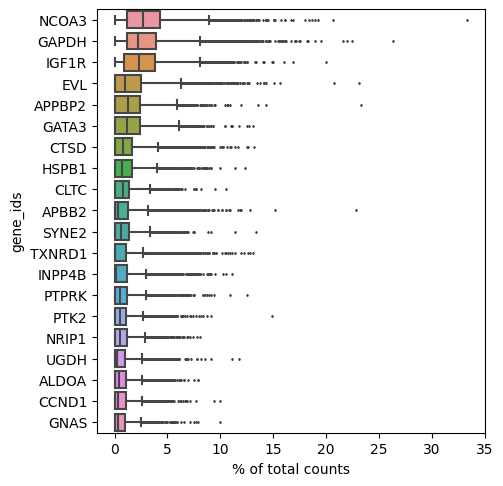

In [12]:
sc.pl.highest_expr_genes(adata, n_top=20, )


In [13]:
# check we don't have any weird cell types
adata.obs["scpred_CellType"].value_counts()


MCF7    6712
A549    3433
Name: scpred_CellType, dtype: int64

In [14]:
# write out data for BP and cibersort
dense_matrix = adata.X.todense()

sc_profile_file = os.path.join(aug_data_path, f"{res_name}_sig.pkl")
sc_profile_path = Path(sc_profile_file)

dense_df = pd.DataFrame(dense_matrix, columns = adata.var['gene_ids'])
dense_df.insert(loc=0, column='scpred_CellType', value=adata.obs["scpred_CellType"].to_list())


pickle.dump( dense_df, open( sc_profile_path, "wb" ) )


In [15]:
dense_matrix.shape

(10145, 967)

# Plot Data

/Users/davidnat/Documents/projects/greenelab/buddi_test/.venv/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:378: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


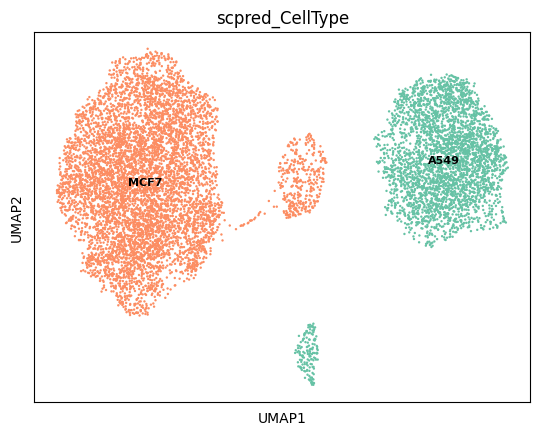

In [16]:
# valculate neighborhood graph
sc.pp.neighbors(adata)

# make umap
sc.tl.umap(adata)

# plot some markers of the RAW data
sc.pl.umap(adata, legend_loc='on data', color='scpred_CellType', legend_fontsize=8)


# Make Pseudobulks

### First do some QC stats

In [17]:
adata.obs["sample_id"].value_counts()


samp1    10145
Name: sample_id, dtype: int64

In [18]:
adata.obs

,cell,Size_Factor,n.umi,hash_umis_W,pval_W,qval_W,top_to_second_best_ratio_W,top_oligo_W,hash_umis_P,pval_P,...,louvain_component,batch,perturbation,cell_line,dose_value,dose_unit,CellType,scpred_CellType,sample_id,stim
cell,,,,,,,,,,,,,,,,,,,,,
A01_E09_RT_BC_101_Lig_BC_109,A01_E09_RT_BC_101_Lig_BC_109,0.516561,695.0,93.0,0.0,0.0,27.803759,plate6_G5,117.0,0.000000e+00,...,2,0,control,A549,0.0,nM,A549,A549,samp1,CTRL
A01_E09_RT_BC_125_Lig_BC_370,A01_E09_RT_BC_125_Lig_BC_370,3.116459,4195.0,261.0,0.0,0.0,92.747985,plate6_G5,354.0,0.000000e+00,...,2,0,control,A549,0.0,nM,A549,A549,samp1,CTRL
A01_E09_RT_BC_138_Lig_BC_69,A01_E09_RT_BC_138_Lig_BC_69,0.447438,604.0,36.0,0.0,0.0,18.978965,plate3_C12,62.0,3.280441e-310,...,2,0,control,A549,0.0,nM,A549,A549,samp1,CTRL
A01_E09_RT_BC_161_Lig_BC_192,A01_E09_RT_BC_161_Lig_BC_192,0.515074,693.0,76.0,0.0,0.0,13.807743,plate6_G11,127.0,0.000000e+00,...,2,0,control,A549,0.0,nM,A549,A549,samp1,CTRL
A01_E09_RT_BC_168_Lig_BC_111,A01_E09_RT_BC_168_Lig_BC_111,0.447438,604.0,72.0,0.0,0.0,24.188289,plate9_D4,76.0,0.000000e+00,...,2,0,control,A549,0.0,nM,A549,A549,samp1,CTRL
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
H12_F10_RT_BC_53_Lig_BC_62,H12_F10_RT_BC_53_Lig_BC_62,0.283077,716.0,138.0,0.0,0.0,50.051123,plate7_D6,156.0,0.000000e+00,...,2,2,control,MCF7,0.0,nM,MCF7,MCF7,samp1,CTRL
H12_F10_RT_BC_66_Lig_BC_183,H12_F10_RT_BC_66_Lig_BC_183,0.279914,709.0,59.0,0.0,0.0,5.197775,plate5_G11,102.0,2.399244e-109,...,2,2,control,MCF7,0.0,nM,MCF7,MCF7,samp1,CTRL
H12_F10_RT_BC_81_Lig_BC_137,H12_F10_RT_BC_81_Lig_BC_137,0.294542,747.0,70.0,0.0,0.0,27.489253,plate9_D4,60.0,4.133161e-215,...,2,2,control,MCF7,0.0,nM,MCF7,MCF7,samp1,CTRL


In [19]:
adata.obs["scpred_CellType"].unique()

['A549', 'MCF7']
Categories (2, object): ['A549', 'MCF7']

### now split test and train cells

In [20]:
# generate cell-type specific split
adata.obs["isTraining"] = "Train"


stim_idx = np.where(adata.obs.stim == "STIM")[0]
adata.obs["isTraining"][stim_idx] = "Test"


/var/folders/64/dljh4z4j4vq9yn4f7wkb2k1h0000gp/T/ipykernel_76691/91422326.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  adata.obs["isTraining"][stim_idx] = "Test"


In [21]:
pd.set_option('display.max_rows', 160)

tab = adata.obs.groupby(['stim', 'isTraining']).size()

tab.unstack()

isTraining,Test,Train
stim,,
CTRL,0,9645
STIM,500,0


In [22]:
tab = adata.obs.groupby(['isTraining', 'sample_id']).size()

tab.unstack()

sample_id,samp1
isTraining,
Test,500
Train,9645


In [23]:
tab = adata.obs.groupby(['stim', 'sample_id']).size()

tab.unstack()

sample_id,samp1
stim,
CTRL,9645
STIM,500


## Make pseudobulks

In [24]:
from importlib import reload  # Python 3.4+
reload(sc_preprocess)


<module 'buddi.preprocessing.sc_preprocess' from '/Users/davidnat/Documents/projects/greenelab/buddi/buddi/preprocessing/sc_preprocess.py'>

In [25]:
adata.var['gene_ids']

gene_ids
TSPAN6      TSPAN6
SCYL3        SCYL3
BAD            BAD
LAP3          LAP3
SNX11        SNX11
            ...   
RBM15B      RBM15B
MRPL12      MRPL12
IKBKE        IKBKE
DUSP14      DUSP14
PIP4K2B    PIP4K2B
Name: gene_ids, Length: 967, dtype: object

In [82]:
# write out the gene ids
gene_pass = adata.var['gene_ids']
gene_out_file = os.path.join(aug_data_path, f"{res_name}_genes.pkl")
gene_out_path = Path(gene_out_file)
pickle.dump( gene_pass, open( gene_out_path, "wb" ) )

# metadata
sample_order = ['samp1']
stim_order = ['STIM', 'CTRL']
train_order = ['Train', 'Test']

# now generate all the proportions
total_meta_df = pd.DataFrame(columns = ["sample_id", "stim", "isTraining"])

# no cell noise 
len_vector = adata.obs["scpred_CellType"].unique().shape[0]
cell_noise = [np.random.lognormal(0, 0, adata.var['gene_ids'].shape[0]) for i in range(len_vector)]

# cell type order
cell_order = adata.obs.scpred_CellType.unique()

# simulate different number of cells
num_cells = 5000
idx = 0
for curr_samp in sample_order:
  for curr_stim in stim_order:
      for curr_train in train_order:

        print(f"running {curr_samp} {curr_stim} {curr_train}")


        # make the pseudobulks
        subset_idx = np.logical_and(adata.obs.sample_id == curr_samp, adata.obs.stim == curr_stim)
        subset_idx = np.where(np.logical_and(subset_idx, adata.obs.isTraining == curr_train))[0]
        if len(subset_idx) == 0:
            continue
        
        temp_adata = adata[subset_idx]

        print("make_prop_and_sum")
        prop_df, pseudobulks_df, test_prop_df, test_pseudobulks_df = sc_preprocess.make_prop_and_sum(temp_adata, 
                                                                                num_samples=1000, 
                                                                                num_cells=num_cells,
                                                                                use_true_prop=False,
                                                                                cell_noise=cell_noise,
                                                                                useSampleNoise=False)
        # number of random pseudobulks
        num_rand_pseudo = pseudobulks_df.shape[0] 

        # get the single cell type proportions
        print("get_single_celltype_prop_matrix")
        ct_prop_df = sc_preprocess.get_single_celltype_prop_matrix(num_samp=100,
                                                                    cell_order=cell_order)

        # now get the cell-type specific pseudobulks
        print("use_prop_make_sum")
        prop_df_sc, pseudobulks_df_sc, _ = sc_preprocess.use_prop_make_sum(temp_adata,  
                                                                            num_cells=num_cells, 
                                                                            props_vec=ct_prop_df, 
                                                                            cell_noise=cell_noise,
                                                                            sample_noise=None,
                                                                            useSampleNoise=False)
        # number of random pseudobulks
        num_ct_pseudo = pseudobulks_df_sc.shape[0] 


        # put them together
        print("concat")        
        prop_df = pd.concat([prop_df,prop_df_sc])
        pseudobulks_df = pd.concat([pseudobulks_df, pseudobulks_df_sc])

        # make the metadata
        num_samps = pseudobulks_df.shape[0] 
        samp_type = ["bulk"]*num_samps
        cell_prop_type = ["random"]*num_rand_pseudo+["cell_type_specific"]*num_ct_pseudo 
        samp_type = ["sc_ref"]*(num_rand_pseudo+num_ct_pseudo)
        
        metadata_df = pd.DataFrame(data = {"sample_id":[curr_samp]*num_samps, 
                                          "stim":[curr_stim]*num_samps,
                                          "isTraining":[curr_train]*num_samps,
                                          "cell_prop_type":cell_prop_type,
                                          "samp_type":samp_type,})

        # make the proportions instead of cell counts
        prop_df = prop_df.div(prop_df.sum(axis=1), axis=0)
        pseudobulk_file = os.path.join(aug_data_path, f"{res_name}_{curr_samp}_{curr_stim}_{curr_train}_pseudo_splits.pkl")
        prop_file = os.path.join(aug_data_path, f"{res_name}_{curr_samp}_{curr_stim}_{curr_train}_prop_splits.pkl")
        meta_file = os.path.join(aug_data_path, f"{res_name}_{curr_samp}_{curr_stim}_{curr_train}_meta_splits.pkl")

        print("write")        
        pseudobulk_path = Path(pseudobulk_file)
        prop_path = Path(prop_file)
        meta_path = Path(meta_file)
        pickle.dump( prop_df, open( prop_path, "wb" ) )
        pickle.dump( pseudobulks_df, open( pseudobulk_path, "wb" ) )
        pickle.dump( metadata_df, open( meta_path, "wb" ) )





running samp1 STIM Train
running samp1 STIM Test
make_prop_and_sum
0
100
200
300
400
500
600
700
800
900
1000
get_single_celltype_prop_matrix
use_prop_make_sum
0
100
concat
write
running samp1 CTRL Train
make_prop_and_sum
0
100
200
300
400
500
600
700
800
900
1000
get_single_celltype_prop_matrix
use_prop_make_sum
0
100
concat
write
running samp1 CTRL Test
